In [1]:
import random
import numpy as np

import tensorflow as tf
print(f"Tensorflow Version: {tf.__version__}")

# gpu_options=tf.GPUOptions(per_process_gpu_memory_fraction=0.333)
# sess=tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

# List physical GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Set memory growth and limit memory usage
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            tf.config.experimental.set_virtual_device_configuration(
                gpu,
                [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=10240)])  # Memory limit in MB
    except RuntimeError as e:
        print(e)

# Now you can create your session or model
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto())

2024-06-06 18:04:37.242238: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-06 18:04:37.242357: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-06 18:04:37.383793: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Tensorflow Version: 2.15.0


In [2]:
seed = 912

# Set random seeds
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
print(f"SEED: {seed}")

SEED: 912


In [11]:
#important library:
from tensorflow.keras.applications import VGG16
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras.callbacks import *

In [4]:
import os
import shutil
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [5]:
import os

def find_Class(directory_path):
    if not os.path.exists(directory_path):
        raise ValueError(f"The directory '{directory_path}' does not exist.")
    if not os.path.isdir(directory_path):
        raise ValueError(f"The path '{directory_path}' is not a directory.")
    
    # Get a list of all entries in the directory
    all_entries = os.listdir(directory_path)
    
    # Filter out only directories
    folders = [entry for entry in all_entries if os.path.isdir(os.path.join(directory_path, entry))]
    
    return folders

In [6]:
DIRECTORY= r"/kaggle/input/soybean-disease-dataset/train"

CATAGORIES= []
try:
    folders = find_Class(DIRECTORY)
    print(f"Directories in '{DIRECTORY}':")
    for folder in folders:
        CATAGORIES.append(folder)
except ValueError as e:
    print(e)

CATAGORIES

Directories in '/kaggle/input/soybean-disease-dataset/train':


['Caterpillar', 'Diabrotica speciosa', 'Healthy']

In [7]:
# Define constants
image_size = (224, 224)  # Rescale images to 224x224 pixels
batch_size = 32
no_of_epoch=50

# Define paths to the original training and test directories
train_dir = '/kaggle/input/soybean-disease-dataset/train'
test_dir = '/kaggle/input/soybean-disease-dataset/test'

# Get the list of subdirectories in the original training directory
subdirectories = os.listdir(train_dir)

# Split the subdirectories into training and validation sets
train_subdirs, validation_subdirs = train_test_split(subdirectories, test_size=0.2, random_state=42)

# Create directories for training and validation data
train_data_dir = 'path/to/train_data'
os.makedirs(train_data_dir, exist_ok=True)

validation_data_dir = 'path/to/validation_data'
os.makedirs(validation_data_dir, exist_ok=True)

# Move images to the corresponding directories
for subdir in subdirectories:
    filenames = os.listdir(os.path.join(train_dir, subdir))
    train_filenames, validation_filenames = train_test_split(filenames, test_size=0.3, random_state=42)

    for filename in train_filenames:
        src = os.path.join(train_dir, subdir, filename)
        dst = os.path.join(train_data_dir, subdir, filename)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.copy(src, dst)

    for filename in validation_filenames:
        src = os.path.join(train_dir, subdir, filename)
        dst = os.path.join(validation_data_dir, subdir, filename)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.copy(src, dst)

# Define data generators with augmentation for training and validation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

# Print the number of samples in each class for training and validation
print("Number of samples in training set:")
print(train_generator.classes)
print("\nNumber of samples in validation set:")
print(validation_generator.classes)

# Evaluate the model
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 4038 images belonging to 3 classes.
Found 1733 images belonging to 3 classes.
Number of samples in training set:
[0 0 0 ... 2 2 2]

Number of samples in validation set:
[0 0 0 ... 2 2 2]
Found 639 images belonging to 3 classes.


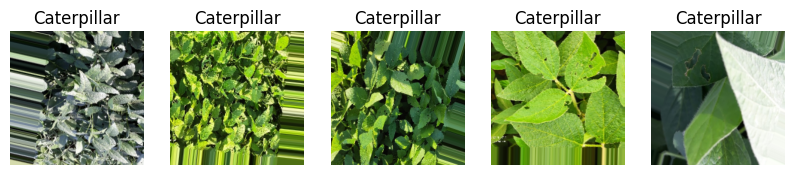

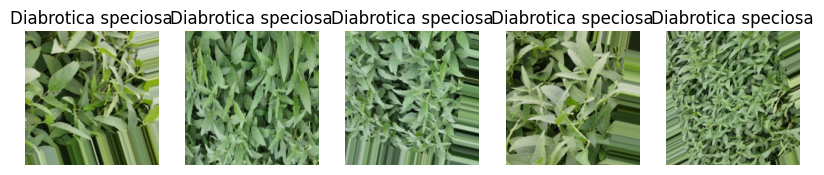

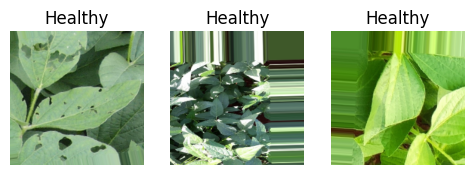

In [8]:
import matplotlib.pyplot as plt

# Define the number of images to plot from each class
num_images_per_class = 5

# Get class indices
class_indices = test_generator.class_indices

# Inverse mapping of class indices to class labels
class_labels = {v: k for k, v in class_indices.items()}

# Plot images from each class
for class_index, class_label in class_labels.items():
    # Find the first num_images_per_class images belonging to the current class
    class_images = [image for image, label in zip(train_generator[0][0], train_generator[0][1]) if label[class_index] == 1][:num_images_per_class]

    # Plot the images
    plt.figure(figsize=(10, 5))
    for i, image in enumerate(class_images):
        plt.subplot(1, num_images_per_class, i + 1)
        plt.imshow(image)
        plt.title(class_label)
        plt.axis('off')
    plt.show()

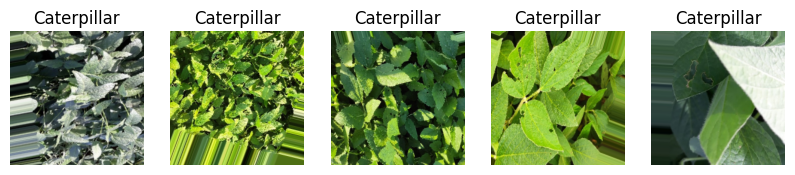

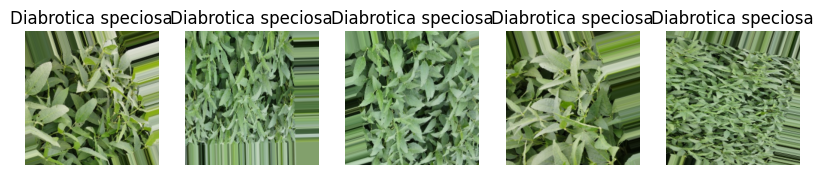

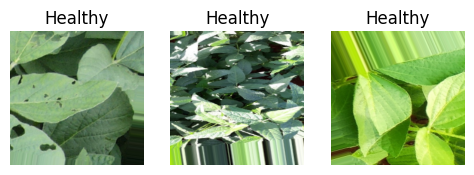

In [9]:
import matplotlib.pyplot as plt

# Define the number of images to plot from each class
num_images_per_class = 5

# Get class indices
class_indices = train_generator.class_indices

class_labels = {v: k for k, v in class_indices.items()}

# Plot images from each class
for class_index, class_label in class_labels.items():
    # Find the first num_images_per_class images belonging to the current class
    class_images = [image for image, label in zip(train_generator[0][0], train_generator[0][1]) if label[class_index] == 1][:num_images_per_class]

    # Plot the images
    plt.figure(figsize=(10, 5))
    for i, image in enumerate(class_images):
        plt.subplot(1, num_images_per_class, i + 1)
        plt.imshow(image)
        plt.title(class_label)
        plt.axis('off')
    plt.show()


In [12]:
checkpoint = ModelCheckpoint('model_best.keras',
                             monitor='val_loss',
                             save_best_only=True,
                             verbose=1,
                             mode='auto',
                             save_weights_only=False)

earlystop = EarlyStopping(monitor='val_accuracy',
                          min_delta=.0001,
                          patience=20,
                          verbose=1,
                          mode='auto',
                          baseline=None,
                          restore_best_weights=True)

reducelr = ReduceLROnPlateau(monitor='val_accuracy',
                             factor=np.sqrt(.1),
                             patience=5,
                             verbose=1,
                             mode='auto',
                             min_delta=.0001,
                             cooldown=0,
                             min_lr=0.000001)

In [13]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.regularizers import l2
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization

# Define the input shape
input_shape = (224, 224, 3)

base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(224, 224, 3), pooling='max')
x = base_model.output
BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
x = layers.Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)  # L2 regularization
x = layers.Dropout(0.5)(x)
output = layers.Dense(3, activation='softmax', kernel_regularizer=l2(0.001))(x)  # L2 regularization
optimizer = tf.keras.optimizers.Adamax(learning_rate=0.0001)

model = models.Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])


74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [15]:
# Train the model and store the training history
history1 = model.fit(train_generator, epochs=no_of_epoch, validation_data=validation_generator,
                     callbacks=[reducelr, earlystop, checkpoint])

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1717697584.119064     141 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1717697584.428815     141 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


  5/127 ━━━━━━━━━━━━━━━━━━━━ 1:00 498ms/step - accuracy: 0.3450 - loss: 4.0641

2024-06-06 18:16:31.642417: E external/local_xla/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module a_inference_one_step_on_data_122884__.85450] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2024-06-06 18:16:39.020426: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 2m7.378207342s

********************************
[Compiling module a_inference_one_step_on_data_122884__.85450] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************


  6/127 ━━━━━━━━━━━━━━━━━━━━ 1:26:32 43s/step - accuracy: 0.3518 - loss: 4.0032

W0000 00:00:1717697799.308145     141 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5520 - loss: 2.4198

W0000 00:00:1717697879.518536     141 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717697908.052717     142 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_loss improved from inf to 0.92037, saving model to model_best.keras
127/127 ━━━━━━━━━━━━━━━━━━━━ 646s 3s/step - accuracy: 0.5526 - loss: 2.4151 - val_accuracy: 0.7611 - val_loss: 0.9204 - learning_rate: 1.0000e-04
Epoch 2/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 510ms/step - accuracy: 0.7279 - loss: 1.0658
Epoch 2: val_loss improved from 0.92037 to 0.70094, saving model to model_best.keras
127/127 ━━━━━━━━━━━━━━━━━━━━ 78s 585ms/step - accuracy: 0.7280 - loss: 1.0654 - val_accuracy: 0.8200 - val_loss: 0.7009 - learning_rate: 1.0000e-04
Epoch 3/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 511ms/step - accuracy: 0.7552 - loss: 0.8610
Epoch 3: val_loss improved from 0.70094 to 0.62620, saving model to model_best.keras
127/127 ━━━━━━━━━━━━━━━━━━━━ 78s 587ms/step - accuracy: 0.7553 - loss: 0.8606 - val_accuracy: 0.8367 - val_loss: 0.6262 - learning_rate: 1.0000e-04
Epoch 4/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 506ms/step - accuracy: 0.7866 - loss: 0.7237
Epoch 4: val_loss improved from 0.62620 to

In [16]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)

# Print the test accuracy
print("Test Accuracy:", test_accuracy)


20/20 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.9763 - loss: 0.1950 
Test Accuracy: 0.9514867067337036


W0000 00:00:1717701785.271256     142 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


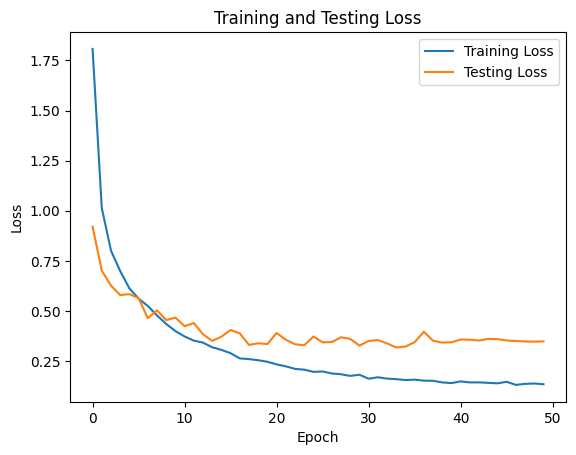

In [17]:
plt.plot(history1.history['loss'], label='Training Loss')
plt.plot(history1.history['val_loss'], label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss')
plt.legend()
plt.show()


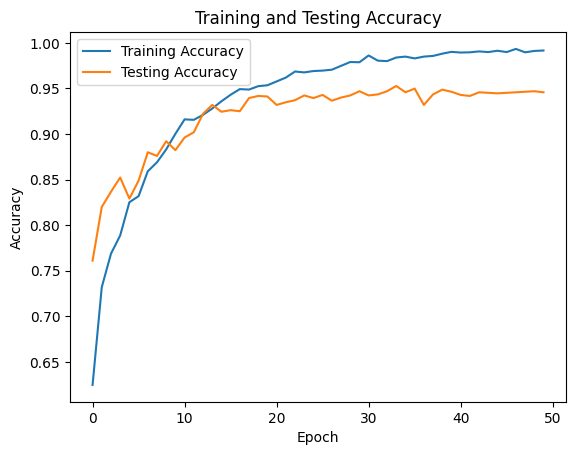

In [18]:
plt.plot(history1.history['accuracy'], label='Training Accuracy')
plt.plot(history1.history['val_accuracy'], label='Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Testing Accuracy')
plt.legend()
plt.show()

In [19]:
predictions = model.predict(test_generator)

predicted_labels = np.argmax(predictions, axis=1)

true_labels = test_generator.classes

conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix)
print('----------------------------------------------------------------------------------------------')

class_report = classification_report(true_labels, predicted_labels)

print("\nClassification Report:")
print(class_report)


 2/20 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step

W0000 00:00:1717701802.815713     142 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


20/20 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step 
Confusion Matrix:
[[326   3   1]
 [ 14 202   4]
 [  8   1  80]]
----------------------------------------------------------------------------------------------

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.99      0.96       330
           1       0.98      0.92      0.95       220
           2       0.94      0.90      0.92        89

    accuracy                           0.95       639
   macro avg       0.95      0.93      0.94       639
weighted avg       0.95      0.95      0.95       639



W0000 00:00:1717701822.472684     142 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


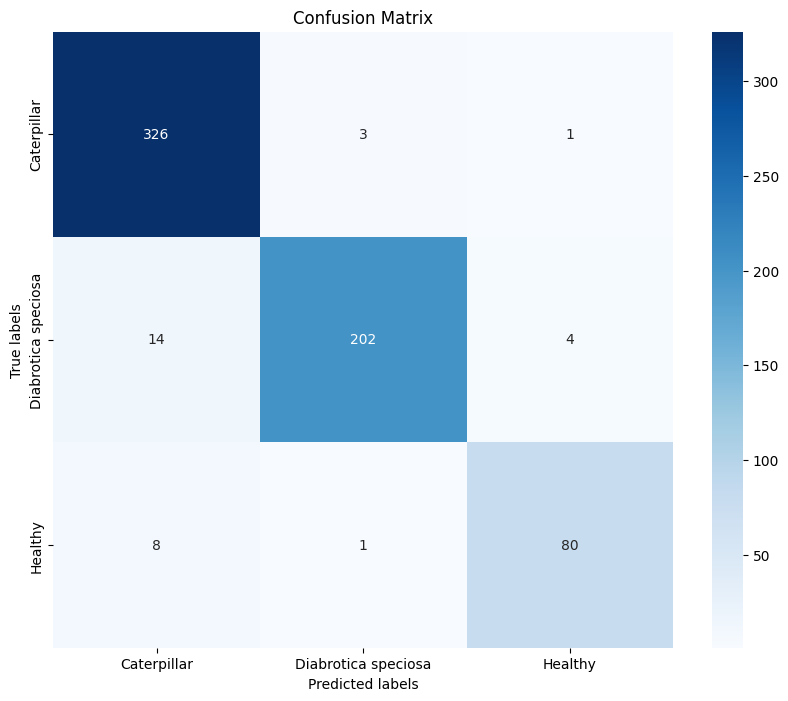

In [20]:
# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()